# 特斯拉ptt輿情分析

## 動機和分析目的
利用ptt對特斯拉的文章，進行以下的分析，可能的分析方向如下：
+ 社群媒體分析：探索特斯拉在不同社群媒體平台上的評論和討論。如特斯拉的技術創新、環保意識等。
+ 市場趨勢預測：分析特斯拉的新產品發布、重大事件或競爭對手的動態對市場的影響，並進行股市趨勢預測。
+ 產品品質分析：使分析消費者的投訴、讚美和建議，並進行情緒分類和主題分析，探討產品品質的缺點與優點。
+ 競爭分析：分析特斯拉與其他競爭對手的比較。特斯拉和其他汽車品牌的情緒和評價，了解特斯拉市場上的定位和競爭策略。

In [6]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint
from collections import defaultdict
import multiprocessing
import os
from getpass import getpass
import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。
import matplotlib.font_manager as fm
import jieba #jieba: 中文斷詞套件。
import jieba.analyse
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker 
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
# from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
import guidedlda
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

## 資料集
資料來源：
+ 資料來源：tarflow PPT車版
+ 關鍵字：特斯拉、Tesla
+ 停用字：馬司克、Musk 
+ 資料筆數：1585篇
+ 訓練資料日期：2023/1/1 - 2024/04/30

## 情緒分析

## 標注文章
三種方式 : guilda、bert_Topic、prompt engineering

###  1. Guild LDA

In [3]:
FontPath = 'data/SourceHanSansTW-Regular.otf' # 設定字型
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

這邊只保留ppt特斯拉版的日期、標題與內容

In [5]:
df = pd.read_csv('data/ppt_Tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,artDate,artTitle,artContent
0,2023-01-01 10:48:19,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....
1,2023-01-01 22:42:25,[問題]特斯拉久了會掉電嗎？,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...


進行前處理，這邊再分出一個topic label欄位

In [6]:
car = df.copy()
car["artContent"] = car["artContent"].str.replace("(http|https)://.*", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("(http|https)://.*", "", regex=True)
car["artContent"] = car["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car["artTitle"] = car["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
car['content'] = car['artContent']
car['topic_label']= ""
car

,artDate,artTitle,artContent,content,topic_label
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,
...,...,...,...,...,...
1581,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,
1582,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,
1583,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,
1584,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,


設定斷詞跟停用字

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stopwords.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

car["words"] = car["content"].apply(getToken)
car.head()

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
2024-06-06 15:19:53,543 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt.big ...
Dumping model to file cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
2024-06-06 15:19:54,017 : DEBUG : Dumping model to file cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.u160d5499c10b2133fd820e5821d8ed10.cache
Loading model cost 0.519 seconds.
2024-06-06 15:19:54,062 : DEBUG : Loading model cost 0.519 seconds.
Prefix dict has been built successfully.
2024-06-06 15:19:54,063 : DEBUG : Prefix dict has been built successfully.


,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,,"[八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,,"[前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 完全, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,,"[出門, 車位, 很煩, 騎家裡, 超舊, 機車, 路上, 有機, 車道, 機車, 機車, ..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,,"[美國, 汽車, 召回, 排名, 揭曉, 第一名, 超過, 萬輛, 進廠, 結束, 迎來, ..."


In [8]:
docs = car['words'].to_list()
docs[0]

['八卦', '官網', '二手車', '第三方', '平台', '便宜', '黨會', '勝利']

In [9]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-06-06 15:19:59,785 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-06 15:19:59,853 : INFO : built Dictionary<28534 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 170299 corpus positions)
2024-06-06 15:19:59,854 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<28534 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...> from 1585 documents (total 170299 corpus positions)", 'datetime': '2024-06-06T15:19:59.854318', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.5-arm64-arm-64bit', 'event': 'created'}
2024-06-06 15:19:59,862 : INFO : discarding 23875 tokens: [('黨會', 1), ('寵物', 4), ('少開', 1), ('掉電', 4), ('數越', 1), ('有載', 2), ('沒人收', 1), ('越充', 1), ('越少電', 1), ('一拳', 2)]...
2024-06-06 15:19:59,862 : INFO : keeping 4659 tokens which were in no less than 5 and no more than 1569 (=99.0%) documents
2024-06-06 15:19:59,866 : INFO : resulting dictionary: Dictionary<4659 

Dictionary<4659 unique tokens: ['二手車', '便宜', '八卦', '勝利', '官網']...>


In [10]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

二手車: 0
便宜: 1
八卦: 2
勝利: 3
官網: 4
平台: 5
第三方: 6
不到: 7
中古: 8
公里: 9
利率: 10
前輩: 11


In [11]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
type(corpus)

list

In [12]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('二手車', '便宜', '八卦', '勝利', '官網', '平台', '第三方', '不到', '中古', '公里')

In [13]:
word2id = dictionary.token2id

我們主要的目的是去找出抱怨相關的主題，而其中又把這些主體細分成有：服務方面、車輛交付方面、性價比方面、安全性方面、使用者體驗方面。
而對應上述五個面向的順序而產生以下的seed list

In [14]:
seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

In [15]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [16]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [17]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-06-06 15:20:00,012 : INFO : n_documents: 1585
2024-06-06 15:20:00,012 : INFO : vocab_size: 4659
2024-06-06 15:20:00,013 : INFO : n_words: 129352
2024-06-06 15:20:00,013 : INFO : n_topics: 6
2024-06-06 15:20:00,013 : INFO : n_iter: 100
2024-06-06 15:20:00,017 : WARNING : all zero row in document-term matrix found
2024-06-06 15:20:00,462 : INFO : <0> log likelihood: -1348898
2024-06-06 15:20:00,583 : INFO : <20> log likelihood: -1048666
2024-06-06 15:20:00,699 : INFO : <40> log likelihood: -1026694
2024-06-06 15:20:00,814 : INFO : <60> log likelihood: -1018774
2024-06-06 15:20:00,928 : INFO : <80> log likelihood: -1014205
2024-06-06 15:20:01,040 : INFO : <99> log likelihood: -1011725


此處是Guild LDA所分出的主題，我們透過選出前20個字來查看LDA所分出的主題跟我們所預期的是否一致
而參數設定上，我們多分出第六類者題最為其他以劃分不在上述五個主題的文章。

In [18]:
# 整理／顯示主題模型結果
n_top_words = 20
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 電動車 電池 汽車 充電 技術 製造商 美國 系統 車廠 駕駛 軟體 電動 市場 豐田 福特 製造 產業 推出 發展 北美
Topic 1: 車型 台灣 電池 交車 續航 售價 價格 電動車 品牌 新車 台幣 馬達 部分 性能 降價 設計 公里 交付 最高 二手車
Topic 2: 中國 電動車 汽車 市場 品牌 台灣 銷售 美國 銷量 歐洲 萬輛 比亞迪 日本 降價 電車 全球 成長 消費者 豐田 車廠
Topic 3: 駕駛 充電 輔助 車道 安全 停車 系統 車體 電動車 車禍 召回 事故 煞車 車子 踏板 新聞 國道 注意 更新 一輛
Topic 4: 充電 電車 油車 車子 空間 超充 原廠 這種 里程 公里 電池 保養 後座 功能 業務 開車 不到 加速 只能 螢幕
Topic 5: 台北市 車馬費 網頁 活動 汽車 專案 地點 訪問 資料 座談會 符合 購車 台北 資格 年次 民國 訪談 研究 會員 人座


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.069871 -0.170997       1        1  31.340895
2     -0.058101  0.160078       2        1  19.119677
3     -0.105791 -0.263821       3        1  17.303071
0     -0.126051  0.154092       4        1  15.577774
1     -0.046541  0.132833       5        1  13.521935
5      0.406355 -0.012185       6        1   3.136648, topic_info=     Term         Freq        Total Category  logprob  loglift
340    中國  1161.000000  1161.000000  Default  30.0000  30.0000
24    電動車  2135.000000  2135.000000  Default  29.0000  29.0000
126    汽車  1126.000000  1126.000000  Default  28.0000  28.0000
92     駕駛   977.000000   977.000000  Default  27.0000  27.0000
25     電池   925.000000   925.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
126    汽車    83.347024  1126.335096   Topic6  -3.8853   0.8583
1765   電子    34.733714    95.677498   Topic6  -4.7606   2.4487
584    完成    28.781064    78.737403   Topic6  -4.9486   2.4556
354    品牌    28.781064   667.514210   Topic6  -4.9486   0.3182
17     新車    27.788955   266.310486   Topic6  -4.9836   1.2020

[413 rows x 6 columns], token_table=      Topic      Freq Term
term                      
279       2  0.034545   一輛
279       3  0.628713   一輛
279       4  0.138179   一輛
279       5  0.200359   一輛
1274      2  1.000064  上半年
...     ...       ...  ...
92        4  0.141247   駕駛
3509      5  1.000831   高度
2574      6  1.005709  高雄市
3596      4  0.999610   鴻海
927       1  1.000625   麻煩

[650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2, 6])

In [19]:
topics_doc = model.transform(X)
print(len(doc_topic))

2024-06-06 15:20:03,346 : WARNING : all zero row in document-term matrix found


1585


In [20]:
for i in range(len(doc_topic)):
    print("topic :{} Document: {}".format(doc_topic[i].argmax(), ', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:5]])))
    car['topic_label'][i] = doc_topic[i].argmax()

topic :2 Document: 二手車, 便宜, 八卦, 勝利, 官網
topic :4 Document: 中古, 里程, 建議, 新車, 垃圾
topic :3 Document: 開車, 直播, 方向盤, 危險, 駕駛
topic :3 Document: 機車, 四輪, 車道, 很煩, 國產車
topic :2 Document: 召回, 萬輛, 美國, 福特, 汽車
topic :0 Document: 按摩, 少見, 旗艦, 日後, 暫時
topic :3 Document: 召回, 回廠, 台車, 車子, 更新
topic :1 Document: 萬輛, 交付, 第四季, 數據, 交車
topic :2 Document: 銷售, 進口, 排名, 進口車, 新車
topic :3 Document: 一名, 罕見, 車上, 並未, 事故
topic :2 Document: 汽車, 一汽, 上汽, 豐田, 大眾
topic :4 Document: 意外, 整理, 前面, 排名, 電動車
topic :0 Document: 充電, 南韓, 電動車, 里程, 續航
topic :0 Document: 充電, 里程, 韓國, 續航, 北美
topic :2 Document: 台幣, 人民幣, 售價, 降價, 大陸
topic :2 Document: 供給, 自然, 需求, 太貴, 平衡
topic :4 Document: 充電, 國道, 服務區, 車位, 充站
topic :2 Document: 降價, 大陸, 市場, 台灣, 折合
topic :2 Document: 來源, 按摩, 有待, 日後, 暫時
topic :2 Document: 澳洲, 銷量, 電動車, 房車, 霸主
topic :4 Document: 強調, 白色, 貼膜, 貼紙, 改裝
topic :0 Document: 電動車, 火災, 南韓, 最終, 迅速
topic :1 Document: 台灣, 降價, 售價, 掛牌, 消息
topic :0 Document: 汽車, 軟體, 定義, 遊戲, 趨勢
topic :4 Document: 充電, 方便, 含稅, 同事, 這台
topic :4 Document: 車頭, 牌子, 有名, 不看, 分辨
t

In [21]:
car.head(20)

,artDate,artTitle,artContent,content,topic_label,words
0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,2,"[八卦, 官網, 二手車, 第三方, 平台, 便宜, 黨會, 勝利]"
1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,4,"[前輩, 中古, 里程, 擔心, 電池, 掉電, 越充, 越少電, 里程, 數越, 少開, ..."
2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,3,"[王家, 徐兆緯, 台北, 前電, 世界冠軍, 日前, 直播, 駕駛, 雙手, 完全, 離開..."
3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,3,"[出門, 車位, 很煩, 騎家裡, 超舊, 機車, 路上, 有機, 車道, 機車, 機車, ..."
4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,2,"[美國, 汽車, 召回, 排名, 揭曉, 第一名, 超過, 萬輛, 進廠, 結束, 迎來, ..."
5,2023-01-02 22:03:33,新聞美國汽車召回排名揭曉第一名超過,,,0,[]
6,2023-01-03 10:14:48,新聞美國汽車召回排名揭曉第一名超過,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,先上美國原文新聞原圖這篇新聞報導的時候特斯拉當年只有個召回特斯拉的個召回裡面有個都只是更新修...,3,"[美國, 新聞, 原圖, 這篇, 新聞報導, 當年, 召回, 召回, 裡面, 更新, 修復,..."
7,2023-01-03 12:31:28,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,1,"[破紀錄, 年交車, 成績單, 揭曉, 總量, 突破, 萬輛, 大關, 正式, 對外, 公布..."
8,2023-01-03 12:32:48,情報年月份臺灣汽車市場銷售報告,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,月份台灣新車市場共掛牌輛電動車賣到第一名絕對是亮點先來看看進口和國產前名還有哪些車款進榜稍後...,2,"[月份, 台灣, 新車, 市場, 掛牌, 電動車, 第一名, 亮點, 進口, 國產, 前名,..."
9,2023-01-04 09:55:23,新聞人奇蹟生還特斯拉衝破公路圍欄墜,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,原文連結原文內容人奇蹟生還特斯拉衝破公路圍欄墜公尺懸崖成廢鐵聯合報編譯張君堯即時報導美國加州...,3,"[奇蹟, 生還, 衝破, 公路, 圍欄, 公尺, 懸崖, 廢鐵, 聯合報, 編譯, 張君堯,..."


## 安全性方面深入分析

## 性價比方面深入分析

## 使用者體驗面深入分析

In [22]:
df = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df_experience = df[df["class"]== "使用者體驗"]
df_experience_pos =df_experience[df_experience['sentiment']=='正面']
df_experience_neg =df_experience[df_experience['sentiment']=='負面']
df_experience

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1571,1571,2024-04-28 02:40:00,電車特斯拉改款後座有螢幕萬,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,昨天去試乘順便看改款的業務有傳簡訊不過新版沒有試乘車第一次開他的方向盤很簡潔我喜歡現在的車做...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""正面""}",正面,使用者體驗
1575,1575,2024-04-29 12:31:50,心得特斯拉煥新版試駕心得,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,完整圖文這次試駕的是全輪驅動版有選配烈焰紅車漆吋輪圈輪胎尺寸搭配的原廠胎是馬牌靜音型輪胎車尾...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面"",""內容"": ""煥新版方向盤握感比舊款...",正面,使用者體驗
1576,1576,2024-04-29 17:57:25,電車拖吊時哨兵模式運作,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,剛看到一台被拖吊大燈在那邊閃這個情況的哨兵模式是會持續地一直運作像是直播那樣還是周期性的一直...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗


In [23]:
df_experience_neg

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
20,20,2023-01-07 16:47:05,問題特斯拉扯著是不是比較少改車啊,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,路上的特斯拉越來越多清一色都是白色少數去貼膜改改顏色加個尾翼然後就沒了不像很多雙或是其他強調...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
24,24,2023-01-10 16:54:06,問題怎麼調適買錯車的心情,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,人生第一台車應該是開心的事我卻很苦惱最近跟同事買了一台二手大概含稅去加州註冊時要繳稅操控加速...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
25,25,2023-01-11 18:27:00,討論不看看外型就知道的品牌,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,對一些人來說不看的話應該分不出來是什麼牌子吧不看第一眼就分辨的出牌子最有名應該就是鼻孔其他就...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",}",負面,使用者體驗
...,...,...,...,...,...,...,...,...
1534,1534,2024-04-20 21:55:03,討論二手兩百多萬舒適省油空間大的轎車,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,如題去年二月買了空間大的沒話說但舒適性油耗就差強人意原先預計一年大概三萬公里油耗每公升公里還...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面"",""內容"": ""空間大但舒適性油耗差，...",負面,使用者體驗
1542,1542,2024-04-22 11:14:13,問題特斯拉業務很急,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,之前聽別人說特斯拉業務不是很在乎業績因為都是在網路上付下訂為什麼我遇到的業務很急看個煥新版一...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1559,1559,2024-04-26 09:08:39,電車台灣特斯拉降價,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,特斯拉出現錯誤台灣版誤植趕快爆買特斯拉現買現賺萬大家可以看看是網頁錯誤還是整個都錯誤,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗
1569,1569,2024-04-26 22:02:33,新聞突破中國低價競爭特斯拉正走入重新調,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,補充一些資訊福斯集團已經宣布使用華為的智能駕駛方案簽約小鵬汽車電動平台讓比亞迪後現在電池電機...,"{""文章分類"": ""使用者體驗"",""情緒"": ""負面""}",負面,使用者體驗


In [24]:
def get_freq_to_wordcloud(input_df):
    jieba.set_dictionary("dict/dict.txt")
    df_experience_pos＿word = input_df.assign(word = input_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)
    df_experience_pos＿word = df_experience_pos＿word.loc[df_experience_pos＿word['word'].str.len() > 1]
    stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
    after_clear_df_pos = df_experience_pos＿word[~df_experience_pos＿word['word'].isin(stopwords)]
    freq_df_clear_pos = pd.DataFrame(pd.value_counts(after_clear_df_pos['word'])).sort_values(by = ['count'], ascending = False).reset_index()
    freq_dict_nostop_pos = freq_df_clear_pos.set_index('word').to_dict()
    freq_dict_nostop_pos = freq_dict_nostop_pos['count']
    return freq_dict_nostop_pos


正面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-06 15:20:04,834 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-06 15:20:04,836 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.244 seconds.
2024-06-06 15:20:05,079 : DEBUG : Loading model cost 0.244 seconds.
Prefix dict has been built successfully.
2024-06-06 15:20:05,080 : DEBUG : Prefix dict has been built successfully.
/Users/arron/Desktop/SMA_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/arron/Desktop/SMA_project/.venv/lib/py

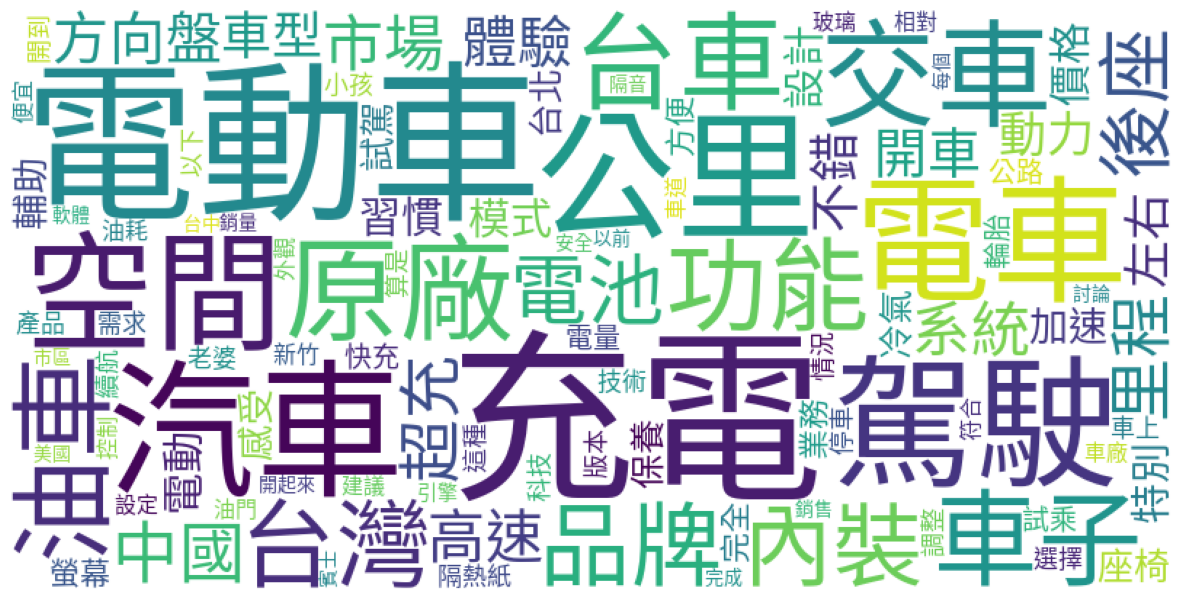

In [25]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_pos)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

負面文字雲

Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
2024-06-06 15:20:06,159 : DEBUG : Building prefix dict from /Users/arron/Desktop/SMA_project/SMA_project/dict/dict.txt ...
Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
2024-06-06 15:20:06,160 : DEBUG : Loading model from cache /var/folders/s0/vxcd6261437fdmx2j76q9tj00000gn/T/jieba.ub420de3365ed380a966939938bdca42e.cache
Loading model cost 0.265 seconds.
2024-06-06 15:20:06,425 : DEBUG : Loading model cost 0.265 seconds.
Prefix dict has been built successfully.
2024-06-06 15:20:06,426 : DEBUG : Prefix dict has been built successfully.


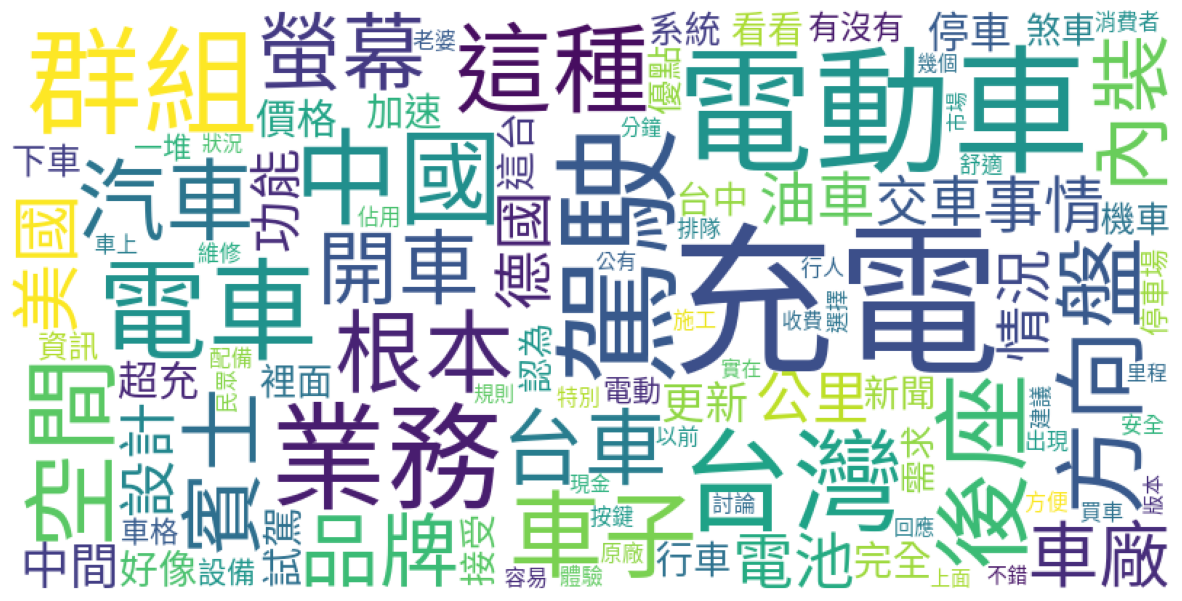

In [26]:
# 繪製文字雲
freq_experience_pos = get_freq_to_wordcloud(df_experience_neg)
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words =100)
wordcloud_nostop.generate_from_frequencies(freq_experience_pos)

plt.figure(figsize = (15,12))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

先放SnowNLP

In [29]:
df_llm = pd.read_csv("data/ppt_tesla_classified_cleaned.csv")
df = pd.read_csv('./data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df_service = pd.concat([df, df_llm[['system_id','class']]], axis=1)
df_service = df_service[df_service['class'] == "使用者體驗"]
df_service

,artDate,artTitle,artContent,system_id,class
2,2023-01-02 12:47:31,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,2.0,使用者體驗
3,2023-01-02 18:01:04,[討論]是不是真的有些四輪覺得自己是大爺？,如題 本身開特斯拉\n\n最近出門覺得找車位很煩都騎家裡超舊機車\n\n基本上在路上有機車道...,3.0,使用者體驗
20,2023-01-07 16:47:05,[問題]特斯拉扯著是不是比較少改車啊,路上的特斯拉 越來越多\n清一色都是白色\n少數去貼膜 改改顏色 加個尾翼\n然後就.......,20.0,使用者體驗
24,2023-01-10 16:54:06,[問題]怎麼調適買錯車的心情,人生第一台車應該是開心的事，我卻很苦惱\n\n最近跟同事買了一台二手2022 Tesla M...,24.0,使用者體驗
25,2023-01-11 18:27:00,[討論]不看LOGO看外型就知道的品牌?,對一些人來說 不看LOGO的話\n應該分不出來是什麼牌子吧\n\n不看LOGO 第一眼就分辨...,25.0,使用者體驗
...,...,...,...,...,...
1569,2024-04-26 19:22:08,[新聞]10年維修成本誰最省？美消費者報告：特,原文連結：\nhttps://tinyurl.com/2zqwuwvv\n原文內容：\n10...,1569.0,使用者體驗
1571,2024-04-27 14:49:57,[新聞]中國燃油車佔比首次跌破50%,原文連結：\nhttps://tinyurl.com/27pws8tr\n原文內容：\n\n...,1571.0,使用者體驗
1575,2024-04-29 11:50:48,[討論]這感覺已經不對,之前特斯拉傳 要推出平價車\n\n我本來要買Colt Plus\n\n看到這個消息 想說等看...,1575.0,使用者體驗
1576,2024-04-29 12:31:50,[心得]特斯拉Model3煥新版試駕心得,完整圖文：\nhttps://supr.link/eG84Y\n這次試駕的是Long Ran...,1576.0,使用者體驗


In [ ]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [ ]:
# 自定義辭典
with open('./dict/Tesla_dict.txt') as f:
    lines = f.read().splitlines()

userdict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(userdict)
print(dictionary2)

In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(df_service)

In [ ]:
# 將文章存成csv
pos_table.to_csv("./ckipdata/pos_table_Teala.csv", index = False)
entity_table.to_csv("./ckipdata/entity_table_Tesla.csv", index = False)
sentence_table.to_csv("./ckipdata/sentence_table_Tesla.csv", index = False)

In [ ]:
sentence_table = pd.read_csv("./ckipdata/sentence_table_Tesla.csv") #匯入資料
sentiment_date = pd.merge(sentence_table,df_service[['system_id','artDate','artTitle','class']],on='system_id',how='left').dropna()
sentiment_date.head(3)

In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

In [ ]:
sentiment_date['sentimentValue'].describe()

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

In [ ]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

In [ ]:
# 篩時間
filter_sentiment = sent_date.loc[sent_date['sentimentValue'] < 0.3]
filter_sentiment.to_csv("filter_sentiment.csv", index = False)
filter_sentiment.head()

In [ ]:
filter_sentiment['artTitle']
set(filter_sentiment['artTitle'].tolist())

In [ ]:
# Define the regular expression pattern for special symbols
sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：_/\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'

# Remove special symbols from the 'sentence' column
filter_sentiment['sentence'] = filter_sentiment['sentence'].apply(lambda x: re.sub(sepical_symbols, '', x))
filter_sentiment = filter_sentiment[filter_sentiment['sentence'] != '']

# Save the filtered DataFrame to a CSV file
filter_sentiment.to_csv("filter_sentiment.csv", index=False)

# Display the first few rows of the filtered DataFrame
filter_sentiment.head()

In [ ]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment, pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

In [ ]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [ ]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
#stop_words_pos.extend((最多','提供'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

Bigram

## 服務方面深入分析